def loaded
one dim min_length= 10 max_length= 2000
two dim min_length= 10 max_length= 2000
one dim min_length= 10 max_length= 999
number of twind less then 100: 6293
total number of 1D dataset 16618


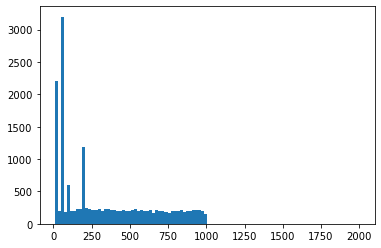

one dim min_length= 10 max_length= 2000
two dim min_length= 10 max_length= 2000
one dim min_length= 10 max_length= 999
number of twind less then 100: 6303
total number of 1D dataset 16618


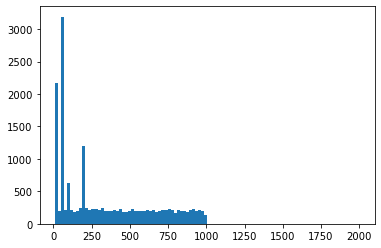

In [1]:
#### Task 2

import numpy as np
from matplotlib import pyplot as plt
import os
import pickle
import time
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator, AutoMinorLocator
from scipy import interpolate
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import anderson
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))

def TMSD(traj, t_lags):
    ttt = np.zeros_like(t_lags, dtype= float)
    for idx, t in enumerate(t_lags): 
        for p in range(len(traj)-t):
            ttt[idx] += (traj[p]-traj[p+t])**2            
        ttt[idx] /= len(traj)-t    
    return ttt

def aging(traj, twind):
    age = np.zeros(len(twind))
    for i, it in enumerate(twind):
        traj_seg = traj[0:it]
        age[i] = TMSD(traj_seg,[1])[0]
    return age

def bound(val):
    if val >= 100:
        val = 100
    elif val <= -100:
        val = -100
    else:
        val = val
    return val

def trajec_feature(traces):
    ## scaling factor
    if np.mean(np.abs(np.diff(traces))) != 0:
        sfac = (np.max(traces)-np.min(traces))/np.mean(np.abs(np.diff(traces)))
    else:
        sfac = 0
    
    mean = bound( np.mean(traces) )
    ms = bound( np.std(traces) )
    m3 = 0 ; m4 = 0
    if ms != 0:
        m3 = bound( np.mean(np.power(traces-mean,3))/(ms**3) )
        m4 = bound( np.mean(np.power(traces-mean,4))/(ms**4) )



    vtraces = np.diff(traces)
    vmean = bound( np.mean(vtraces) )
    vms = bound( np.std(vtraces) )
    vm3 = 0 ; vm4 = 0
    if vms != 0:
        vm3 = bound( np.mean(np.power(vtraces-vmean,3))/(vms**3) )
        vm4 = bound( np.mean(np.power(vtraces-vmean,4))/(vms**4) )

    atraces = np.diff(vtraces)
    amean = bound( np.mean(atraces) )
    ams = bound( np.std(atraces) )
    am3 = 0 ; am4 = 0
    if ams != 0:
        am3 = bound( np.mean(np.power(atraces-amean,3))/(ams**3) )
        am4 = bound( np.mean(np.power(atraces-amean,4))/(ams**4) )


    f2 = bound( np.max(vtraces) - np.min(vtraces) )
    f3 = bound( np.max(atraces) - np.min(atraces) )
    
       
    tlag = np.linspace(1, len(traces)-1, 10, dtype = 'int')
    
    msd = TMSD(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    nw1, nw0 = np.linalg.lstsq(A, np.log(msd), rcond=None)[0]

    nw1 = bound(nw1)
    nw0 = bound(nw0)
    
    tlag = np.linspace(10, len(traces)-1, 10, dtype = 'int')
    age = aging(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    age_nw1, age_nw0 = np.linalg.lstsq(A, np.log(age), rcond=None)[0]
    
    age_nw1 = bound(age_nw1)
    
    sh_stat, sh_p = shapiro(vtraces)
    
    if sh_p >= 0.1:
        sh_stat = -1      
    sh_stat = bound(sh_stat)
    
    if len(vtraces) > 20 :
        nom_stat, nom_p = normaltest(vtraces)
        if nom_p >= 0.1:
            nom_stat = -1
        and_result = anderson(vtraces).statistic
    
    else:
        nom_stat = -0.5
        and_result = -0.5
       
    nom_stat = bound(nom_stat)
    and_result = bound(and_result)

    
    feature = np.asarray([mean, ms, m3, m4, vmean, vms, vm3, vm4, \
                        amean, ams, am3, nw1, nw0, age_nw1, \
                        sfac, am4, f2, f3, sh_stat, and_result])
    
    

    feature = np.append(feature,msd)
    feature = np.append(feature,age)

    return feature


print('def loaded')


filename = './task1.txt'

with open(filename) as data:
    lines = data.readlines() 

onedim_set = []
twodim_set = [[],[]]
threedim_set = [[],[],[]]

for i in range(len(lines)):
    tmp = np.array(lines[i].split(';'),dtype=float)
    if tmp[0] == 1:
        onedim_set.append(tmp[1:])
    if tmp[0] == 2:
        idx = int( (len(tmp) - 1)/2 )
        twodim_set[0].append(tmp[1:idx+1])
        twodim_set[1].append(tmp[idx+1:])

    if tmp[0] == 3:
        idx = int( (len(tmp) - 1)/3 )
        threedim_set[0].append(tmp[1:idx+1])
        threedim_set[1].append(tmp[idx+1:2*idx+1])
        threedim_set[2].append(tmp[2*idx+1:])
        
mint = 1000000 ; maxt = 0

for i in range(len(onedim_set)):
    mint = min(mint, len(onedim_set[i]))
    maxt = max(maxt, len(onedim_set[i]))
print('one dim', 'min_length=', mint, 'max_length=', maxt)

mint = 1000000 ; maxt = 0

for i in range(len(twodim_set[1])):
    mint = min(mint, len(twodim_set[1][i]))
    maxt = max(maxt, len(twodim_set[1][i]))
print('two dim', 'min_length=', mint, 'max_length=', maxt)

mint = 1000000 ; maxt = 0

for i in range(len(threedim_set[2])):
    mint = min(mint, len(threedim_set[2][i]))
    maxt = max(maxt, len(threedim_set[2][i]))
print('one dim', 'min_length=', mint, 'max_length=', maxt)


twind = []
icount = 0

for i in range(len(onedim_set)):
    twind.append(len(onedim_set[i]))
    if len(onedim_set[i]) <=100:
        icount = icount + 1
        
print('number of twind less then 100:', icount)
print('total number of 1D dataset',len(twind))

plt.hist(twind, 100)
plt.show()

task1_set = onedim_set

####################################
filename = './task2.txt'

with open(filename) as data:
    lines = data.readlines() 

onedim_set = []
twodim_set = [[],[]]
threedim_set = [[],[],[]]

for i in range(len(lines)):
    tmp = np.array(lines[i].split(';'),dtype=float)
    if tmp[0] == 1:
        onedim_set.append(tmp[1:])
    if tmp[0] == 2:
        idx = int( (len(tmp) - 1)/2 )
        twodim_set[0].append(tmp[1:idx+1])
        twodim_set[1].append(tmp[idx+1:])

    if tmp[0] == 3:
        idx = int( (len(tmp) - 1)/3 )
        threedim_set[0].append(tmp[1:idx+1])
        threedim_set[1].append(tmp[idx+1:2*idx+1])
        threedim_set[2].append(tmp[2*idx+1:])
        
mint = 1000000 ; maxt = 0

for i in range(len(onedim_set)):
    mint = min(mint, len(onedim_set[i]))
    maxt = max(maxt, len(onedim_set[i]))
print('one dim', 'min_length=', mint, 'max_length=', maxt)

mint = 1000000 ; maxt = 0

for i in range(len(twodim_set[1])):
    mint = min(mint, len(twodim_set[1][i]))
    maxt = max(maxt, len(twodim_set[1][i]))
print('two dim', 'min_length=', mint, 'max_length=', maxt)

mint = 1000000 ; maxt = 0

for i in range(len(threedim_set[2])):
    mint = min(mint, len(threedim_set[2][i]))
    maxt = max(maxt, len(threedim_set[2][i]))
print('one dim', 'min_length=', mint, 'max_length=', maxt)


twind = []
icount = 0

for i in range(len(onedim_set)):
    twind.append(len(onedim_set[i]))
    if len(onedim_set[i]) <=100:
        icount = icount + 1
        
print('number of twind less then 100:', icount)
print('total number of 1D dataset',len(twind))

plt.hist(twind, 100)
plt.show()

task2_set = onedim_set

In [2]:
tstart = time.time()


ndiv = 100
f_dim = 40
namp = 0.001

task1_data = np.zeros((len(task1_set),ndiv,1))
task1_info = np.zeros((len(task1_set),f_dim))

task2_data = np.zeros((len(task2_set),ndiv,1))
task2_info = np.zeros((len(task2_set),f_dim))

scaler = MinMaxScaler(feature_range=(0, 1))

for i in range(len(task1_set)):
    trajec = task1_set[i]
    
    trajec_mov = np.zeros((len(trajec)-3))
    for it in range(len(trajec)-3):
        trajec_mov[it] = np.mean(trajec[it:it+3])

    ret = len(trajec_mov)
    convt = ndiv/ret
    
    ti_new = np.linspace(0, len(trajec_mov), ndiv)
    postck = interpolate.splrep(np.arange(0, len(trajec_mov), 1), trajec_mov)
    trajec = interpolate.splev(ti_new, postck) 
    
    strajec = scaler.fit_transform(np.reshape(trajec,(-1,1))).T[0]  
    strajec = strajec + namp * convt * np.random.normal(0,1,size=ndiv)

    task1_data[i,:,0] = strajec 
    task1_info[i] = trajec_feature(strajec)
    
for i in range(len(task2_set)):
    trajec = task2_set[i]
    
    trajec_mov = np.zeros((len(trajec)-3))
    for it in range(len(trajec)-3):
        trajec_mov[it] = np.mean(trajec[it:it+3])

    ret = len(trajec_mov)
    convt = ndiv/ret
    
    ti_new = np.linspace(0, len(trajec_mov), ndiv)
    postck = interpolate.splrep(np.arange(0, len(trajec_mov), 1), trajec_mov)
    trajec = interpolate.splev(ti_new, postck) 

    strajec = scaler.fit_transform(np.reshape(trajec,(-1,1))).T[0]  
    strajec = strajec + namp * convt * np.random.normal(0,1,size=ndiv)

    task2_data[i,:,0] = strajec 
    task2_info[i] = trajec_feature(strajec)
    
tend = time.time()

print('data ready')
print('elapsed time: {0:.0f} min {1:.0f} sec'.format((tend-tstart)//60, (tend-tstart)%60))

print(np.sum(task1_info), np.sum(task2_info))

data ready
elapsed time: 2 min 7 sec
763459.9067180853 851350.4642860595


In [3]:
from keras.models import load_model


task1_0 = '../USED_MACHINE/task1_0_nmax5000.hdf5'
task2_0 = '../USED_MACHINE/task2_0_nmax5000.hdf5'

task1_1 = '../USED_MACHINE/task1_1_nmax5000.hdf5'
task2_1 = '../USED_MACHINE/task2_1_nmax5000.hdf5'

task1_2 = '../USED_MACHINE/task1_2_nmax5000.hdf5'
task2_2 = '../USED_MACHINE/task2_2_nmax5000.hdf5'

task1_3 = '../USED_MACHINE/task1_3_nmax5000.hdf5'
task2_3 = '../USED_MACHINE/task2_3_nmax5000.hdf5'

task1_4 = '../USED_MACHINE/task1_4_nmax5000.hdf5'
task2_4 = '../USED_MACHINE/task2_4_nmax5000.hdf5'

task1_5 = '../USED_MACHINE/task1_0_nmax10000.hdf5'
task2_5 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_6 = '../USED_MACHINE/task1_1_nmax10000.hdf5'
task2_6 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_7 = '../USED_MACHINE/task1_2_nmax10000.hdf5'
task2_7 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_8 = '../USED_MACHINE/task1_3_nmax10000.hdf5'
task2_8 = '../USED_MACHINE/task2_0_nmax10000.hdf5'

task1_9 = '../USED_MACHINE/task1_4_nmax10000.hdf5'
task2_9 = '../USED_MACHINE/task2_0_nmax10000.hdf5'


task1_model_0 = load_model(task1_0)
task2_model_0 = load_model(task2_0)

task1_model_1 = load_model(task1_1)
task2_model_1 = load_model(task2_1)

task1_model_2 = load_model(task1_2)
task2_model_2 = load_model(task2_2)

task1_model_3 = load_model(task1_3)
task2_model_3 = load_model(task2_3)

task1_model_4 = load_model(task1_4)
task2_model_4 = load_model(task2_4)


task1_model_5 = load_model(task1_5)
task2_model_5 = load_model(task2_5)

task1_model_6 = load_model(task1_6)
task2_model_6 = load_model(task2_6)

task1_model_7 = load_model(task1_7)
task2_model_7 = load_model(task2_7)

task1_model_8 = load_model(task1_8)
task2_model_8 = load_model(task2_8)

task1_model_9 = load_model(task1_9)
task2_model_9 = load_model(task2_9)





print('Machine loaded')



Machine loaded


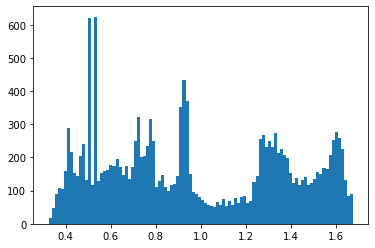

In [4]:
task1_results_0 = task1_model_0.predict([task1_data, task1_info])
task1_results_1 = task1_model_1.predict([task1_data, task1_info])
task1_results_2 = task1_model_2.predict([task1_data, task1_info])
task1_results_3 = task1_model_3.predict([task1_data, task1_info])
task1_results_4 = task1_model_4.predict([task1_data, task1_info])
task1_results_5 = task1_model_5.predict([task1_data, task1_info])
task1_results_6 = task1_model_6.predict([task1_data, task1_info])
task1_results_7 = task1_model_7.predict([task1_data, task1_info])
task1_results_8 = task1_model_8.predict([task1_data, task1_info])
task1_results_9 = task1_model_9.predict([task1_data, task1_info])


results_file_task1 = open('./gen_result/task1.txt', 'w')

results_summary_task1 = []

icount = 0
for n in range(len(task1_results_0)):
    
    alpha = ( task1_results_0[n][0] + task1_results_1[n][0] \
                 + task1_results_2[n][0] + task1_results_3[n][0] \
                 + task1_results_4[n][0] + task1_results_5[n][0] \
                 + task1_results_6[n][0] + task1_results_7[n][0] \
                 + task1_results_8[n][0] + task1_results_9[n][0] ) / 10
                          
    final_evaluation = '1; {0:f} \n'.format(alpha)
    results_file_task1.write(final_evaluation)
    results_summary_task1.append(alpha)
    
results_file_task1.close()

plt.hist(results_summary_task1, bins=100)
plt.show()
   
    





In [5]:
def trajec_feature_xgboost(traces):
    ## scaling factor
    if np.mean(np.abs(np.diff(traces))) != 0:
        sfac = (np.max(traces)-np.min(traces))/np.mean(np.abs(np.diff(traces)))
    else:
        sfac = 0
    
    mean = bound( np.mean(traces) )
    ms = bound( np.std(traces) )
    m3 = 0 ; m4 = 0
    if ms != 0:
        m3 = bound( np.mean(np.power(traces-mean,3))/(ms**3) )
        m4 = bound( np.mean(np.power(traces-mean,4))/(ms**4) )



    vtraces = np.diff(traces)
    vmean = bound( np.mean(vtraces) )
    vms = bound( np.std(vtraces) )
    vm3 = 0 ; vm4 = 0
    if vms != 0:
        vm3 = bound( np.mean(np.power(vtraces-vmean,3))/(vms**3) )
        vm4 = bound( np.mean(np.power(vtraces-vmean,4))/(vms**4) )

    atraces = np.diff(vtraces)
    amean = bound( np.mean(atraces) )
    ams = bound( np.std(atraces) )
    am3 = 0 ; am4 = 0
    if ams != 0:
        am3 = bound( np.mean(np.power(atraces-amean,3))/(ams**3) )
        am4 = bound( np.mean(np.power(atraces-amean,4))/(ams**4) )


    f2 = bound( np.max(vtraces) - np.min(vtraces) )
    f3 = bound( np.max(atraces) - np.min(atraces) )
    
       
    tlag = np.linspace(1, len(traces)-1, 10, dtype = 'int')
    
    msd = TMSD(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    nw1, nw0 = np.linalg.lstsq(A, np.log(msd), rcond=None)[0]

    nw1 = bound(nw1)
    nw0 = bound(nw0)
    
    tlag = np.linspace(10, len(traces)-1, 10, dtype = 'int')
    age = aging(traces, tlag)
    A = np.vstack([np.log(tlag), np.ones(len(np.log(tlag)))]).T
    age_nw1, age_nw0 = np.linalg.lstsq(A, np.log(age), rcond=None)[0]
    
    age_nw1 = bound(age_nw1)

    sh_stat, sh_p = shapiro(vtraces)
    
    if sh_p >= 0.1:
        sh_stat = -1      
    sh_stat = bound(sh_stat)
    
    if len(vtraces) > 20 :
        nom_stat, nom_p = normaltest(vtraces)
        if nom_p >= 0.1:
            nom_stat = -1
        and_result = anderson(vtraces).statistic
    
    else:
        nom_stat = -0.5
        and_result = -0.5
       
    nom_stat = bound(nom_stat)
    and_result = bound(and_result)

#     print(tlag)
    
    feature = np.asarray([mean, ms, m3, m4, vmean, vms, vm3, vm4, \
                        amean, ams, am3, nw1, nw0, age_nw1, \
                        sfac, am4, f2, f3, sh_stat, and_result])
    
    
    return feature


task2_results_0 = task2_model_0.predict([task2_data, task2_info])
task2_results_1 = task2_model_1.predict([task2_data, task2_info])
task2_results_2 = task2_model_2.predict([task2_data, task2_info])
task2_results_3 = task2_model_3.predict([task2_data, task2_info])
task2_results_4 = task2_model_4.predict([task2_data, task2_info])
task2_results_5 = task2_model_5.predict([task2_data, task2_info])
task2_results_6 = task2_model_6.predict([task2_data, task2_info])
task2_results_7 = task2_model_7.predict([task2_data, task2_info])
task2_results_8 = task2_model_8.predict([task2_data, task2_info])
task2_results_9 = task2_model_9.predict([task2_data, task2_info])


icount = 0
features = np.zeros((task2_data.shape[0], 20))

for i in range(task2_data.shape[0]):
    trajec = task2_data[icount,:,0]
    features[i] = trajec_feature_xgboost(trajec)

add_feature = []
label_set = []

for i in range(task2_data.shape[0]):
    add0 = np.append(features[i], task2_results_0[i]) 
    add1 = np.append(add0, task2_results_1[i]) 
    add2 = np.append(add1, task2_results_2[i]) 
    add3 = np.append(add2, task2_results_3[i]) 
    add4 = np.append(add3, task2_results_4[i]) 
    add5 = np.append(add4, task2_results_5[i]) 
    add6 = np.append(add5, task2_results_6[i]) 
    add7 = np.append(add6, task2_results_7[i]) 
    add8 = np.append(add7, task2_results_8[i]) 
    add9 = np.append(add8, task2_results_9[i]) 
    add_feature.append(add9)
    
print( len(add_feature[0]) )



90


In [12]:
from keras.utils import to_categorical

model = pickle.load(open('../USED_MACHINE/reference_model.dat', 'rb'))
# model = pickle.load(open('../USED_MACHINE/reference_model_single_try.dat', 'rb'))


add_feature = np.asarray(add_feature)
xgb_results = model.predict(add_feature)
results = np.zeros((len(xgb_results)))

icount = 0
for i in range(len(xgb_results)):
    if xgb_results[i] <= 4:
        results[i] =  xgb_results[i]
    elif xgb_results[i] == 5:
        results[i] =  2
    elif xgb_results[i] <= 6:
        results[i] =  4
    else:
        icount = icount + 1
print(icount)
    

results_file = open('./gen_result/task2.txt', 'w')
results_summary = []
results_onehot = to_categorical(results, num_classes=5)

for idx, result in enumerate(results_onehot):
    
    final_evaluation = '1; {0:.3f} ; {1:.3f} ; {2:.3f} ; {3:.3f} ; {4:.3f}\n'.format\
                        (results_onehot[idx][0], results_onehot[idx][1], results_onehot[idx][2], \
                         results_onehot[idx][3], results_onehot[idx][4])
    results_file.write(final_evaluation)
    if (np.sum(results_onehot[idx]) - 1 )** 2  >= 0.001 :
        print('check point', np.round(np.sum(result),3), np.round(result,3))      
    results_summary.append(np.argmax(result))
    
results_file.close()

plt.hist(results_summary, bins=[-0.5,0.5,1.5,2.5,3.5,4.5])
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../USED_MACHINE/reference_model.dat'